# Chapter 6

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200 # num grant proposals
p = 0.1 # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw # total score
q = np.quantile(s, 1-p) # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

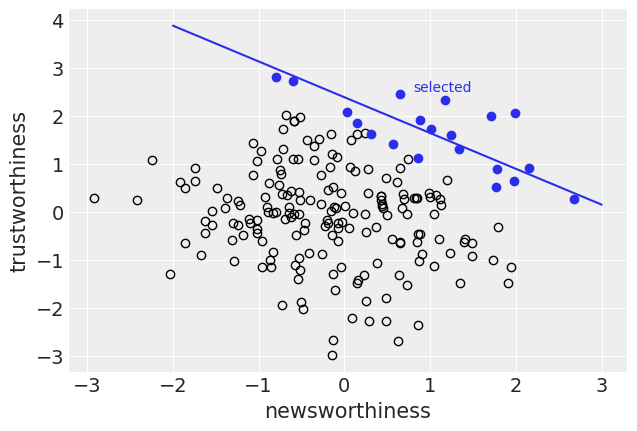

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor='k', color=(0,0,0,0))
plt.scatter(nw[selected], tw[selected], color='C0')
plt.text(0.8, 2.5, 'selected', color='C0')

# correlation line
xn = np.array([-2,3])
plt.plot(xn, tw[selected].mean() + cor[0,1] * (xn - nw[selected].mean()))

plt.xlabel('newsworthiness')
plt.ylabel('trustworthiness')

#### Code 6.2

In [5]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(np.vstack([height,leg_left,leg_right]).T, columns=['height', 'leg_left', 'leg_right'])  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
with pm.Model() as m_6_1:
    a = pm.Normal('a', 10, 100)
    bl = pm.Normal('bl', 2, 10)
    br = pm.Normal('br', 2, 10)
    
    mu = pm.Deterministic('mu', a + bl * d.leg_left + br * d.leg_right)
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    
    m_6_1_trace = pm.sample()

az.summary(m_6_1_trace, var_names=['~mu'], credible_interval=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [01:04<00:00, 30.93draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.995,0.350,0.441,1.536,0.015,0.011,516.0,477.0,517.0,471.0,1.00
bl,-1.926,2.232,-5.366,1.422,0.124,0.096,323.0,270.0,333.0,417.0,1.01
br,3.948,2.220,0.515,7.243,0.123,0.094,327.0,282.0,336.0,417.0,1.01
sigma,0.643,0.047,0.577,0.725,0.002,0.001,594.0,592.0,612.0,507.0,1.00


#### Code 6.4

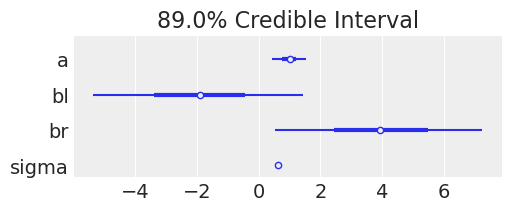

In [7]:
_ = az.plot_forest(m_6_1_trace, var_names=['~mu'], combined=True, figsize=[5, 2], credible_interval=0.89)

#### Code 6.5 & 6.6

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

Text(0.5, 0, 'sum of bl and br')

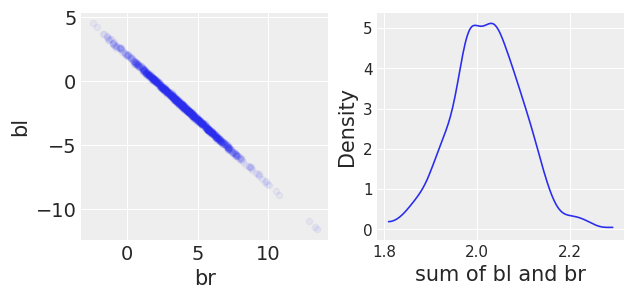

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

# code 6.5
ax1.scatter(m_6_1_trace[br], m_6_1_trace[bl], alpha=0.05, s=20)
ax1.set_xlabel('br')
ax1.set_ylabel('bl')

# code 6.6
az.plot_kde(m_6_1_trace[br] + m_6_1_trace[bl], ax=ax2)
ax2.set_ylabel('Density')
ax2.set_xlabel('sum of bl and br')

#### Code 6.7

In [9]:
with pm.Model() as m_6_2:
    a = pm.Normal('a', 10, 100)
    bl = pm.Normal('bl', 2, 10)
    
    mu = pm.Deterministic('mu', a + bl * d.leg_left)
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    
    m_6_2_trace = pm.sample()

az.summary(m_6_2_trace, var_names=['~mu'], credible_interval=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 660.54draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.906,0.328,0.369,1.395,0.017,0.012,360.0,345.0,362.0,351.0,1.0
bl,2.036,0.071,1.935,2.154,0.004,0.003,354.0,354.0,358.0,326.0,1.0
sigma,0.653,0.047,0.577,0.725,0.002,0.002,402.0,402.0,401.0,403.0,1.0


#### Code 6.8

In [10]:
d = pd.read_csv('Data/milk.csv', sep=';')

d.loc[:, 'K'] = (d.loc[:, 'kcal.per.g'] - d.loc[:, 'kcal.per.g'].mean()) / d.loc[:, 'kcal.per.g'].std()
d.loc[:, 'F'] = (d.loc[:, 'perc.fat'] - d.loc[:, 'perc.fat'].mean()) / d.loc[:, 'perc.fat'].std()
d.loc[:, 'L'] = (d.loc[:, 'perc.lactose'] - d.loc[:, 'perc.lactose'].mean()) / d.loc[:, 'perc.lactose'].std()

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### Code 6.9

In [11]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal('a', 0, 0.2)
    bF = pm.Normal('bF', 0, 0.5)
        
    mu = pm.Deterministic('mu', a + bF * d.F)
    sigma = pm.Exponential('sigma', 1)

    K = pm.Normal('K', mu, sigma, observed=d.K)
    
    m_6_3_trace = pm.sample()

az.summary(m_6_3_trace, var_names=['~mu'], credible_interval=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1849.02draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.003,0.089,-0.128,0.145,0.003,0.003,1095.0,424.0,1117.0,616.0,1.0
bF,0.851,0.095,0.702,1.003,0.003,0.002,992.0,992.0,1046.0,574.0,1.0
sigma,0.492,0.072,0.375,0.598,0.003,0.002,740.0,684.0,904.0,613.0,1.0


In [12]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal('a', 0, 0.2)
    bL = pm.Normal('bF', 0, 0.5)
        
    mu = pm.Deterministic('mu', a + bL * d.L)
    sigma = pm.Exponential('sigma', 1)

    K = pm.Normal('K', mu, sigma, observed=d.K)
    
    m_6_4_trace = pm.sample()
    
az.summary(m_6_4_trace, var_names=['~mu'], credible_interval=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1820.75draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.003,0.074,-0.110,0.123,0.002,0.002,885.0,624.0,889.0,539.0,1.0
bF,-0.900,0.075,-1.027,-0.794,0.002,0.002,917.0,917.0,927.0,717.0,1.0
sigma,0.411,0.058,0.326,0.503,0.002,0.001,1041.0,1020.0,1038.0,600.0,1.0


#### Code 6.10

In [13]:
with pm.Model() as m_6_5:
    a = pm.Normal('a', 0, 0.2)
    bF = pm.Normal('bF', 0, 0.5)
    bL = pm.Normal('bL', 0, 0.5)
        
    mu = pm.Deterministic('mu', a + bF * d.F + bL * d.L)
    sigma = pm.Exponential('sigma', 1)

    K = pm.Normal('K', mu, sigma, observed=d.K)
    
    m_6_5_trace = pm.sample()
    
az.summary(m_6_5_trace, var_names=['~mu'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 889.74draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.075,-0.151,0.130,0.003,0.003,683.0,403.0,661.0,644.0,1.00
bF,0.244,0.212,-0.144,0.644,0.011,0.008,392.0,392.0,389.0,344.0,1.01
bL,-0.673,0.209,-1.064,-0.286,0.010,0.008,401.0,381.0,398.0,369.0,1.01
sigma,0.417,0.065,0.308,0.535,0.003,0.002,408.0,408.0,364.0,272.0,1.01


#### Code 6.11

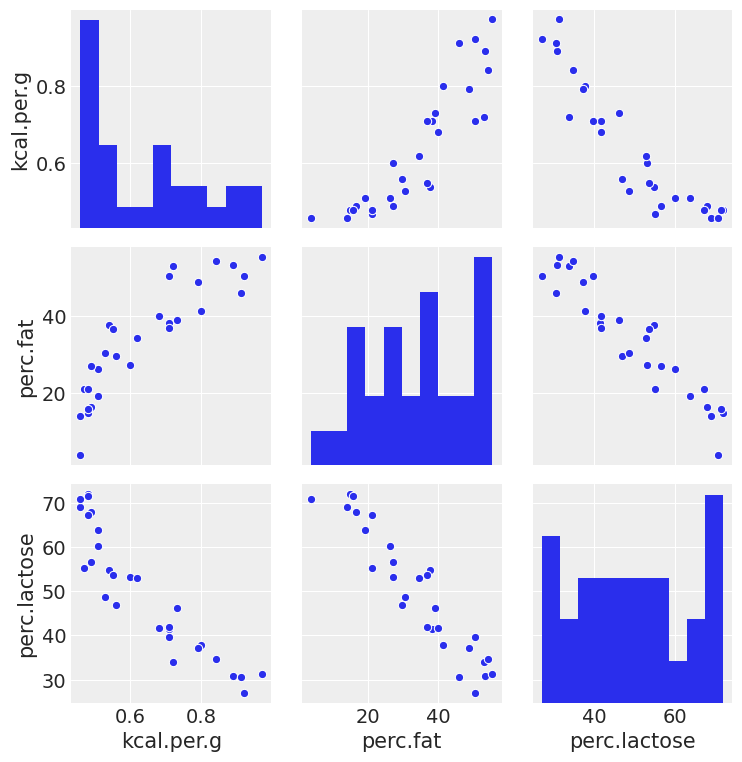

In [14]:
sns.pairplot(d.loc[:, ['kcal.per.g', 'perc.fat', 'perc.lactose']])

#### Code 6.12

Text(0, 0.5, 'correlation')

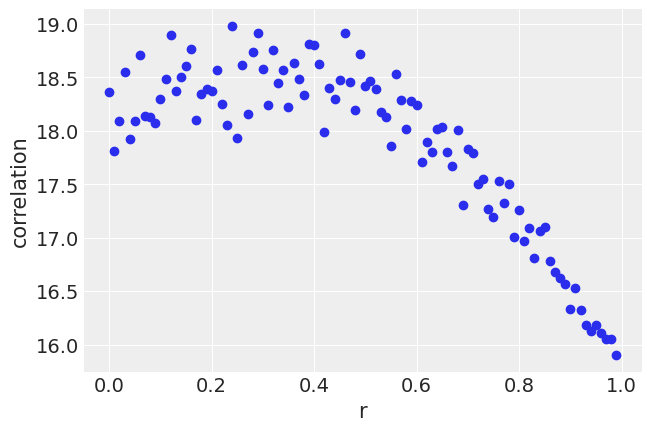

In [15]:
def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d.loc[:, 'perc.fat'],
                         scale=np.sqrt((1 - r**2) * np.var(d.loc[:, 'perc.fat'])))
    p, cov = np.polyfit(d.loc[:, 'kcal.per.g'], d.loc[:, 'perc.fat'] + x, deg=1, cov=True)
    return np.sqrt(np.diag(cov))[0]

def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(100)])

r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel('r')
plt.ylabel('correlation')

#### Code 6.13

In [16]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0,1], N/2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})

d.describe().T

,count,mean,std,min,25%,50%,75%,max
h0,100.0,10.032927,1.865150,4.939658,8.835749,9.852694,11.236529,14.233877
h1,100.0,14.251089,2.428340,7.952614,12.684936,14.587179,16.234033,18.693188
treatment,100.0,0.500000,0.502519,0.000000,0.000000,0.500000,1.000000,1.000000
fungus,100.0,0.260000,0.440844,0.000000,0.000000,0.000000,1.000000,1.000000


#### Code 6.14

In [17]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,1.034,0.265,0.573,1.521,0.003,0.002,9749.0,9737.0,9769.0,9324.0,NaN


#### Code 6.15

In [18]:
with pm.Model() as m_6_6:
    p = pm.Lognormal('p', 0, 0.25)
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1994.57draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.403,0.018,1.369,1.435,0.001,0.000,1014.0,1014.0,1010.0,594.0,1.01
sigma,1.874,0.133,1.648,2.148,0.004,0.003,1026.0,1020.0,1021.0,747.0,1.00


#### Code 6.16

In [19]:
with pm.Model() as m_6_7:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    bf = pm.Normal('bf', 0, 0.5)
    
    p = a + bt * d.treatment + bf * d.fungus
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1017.76draws/s]
The acceptance probability does not match the target. It is 0.8936683270553085, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.473,0.020,1.432,1.508,0.001,0.001,630.0,624.0,636.0,757.0,1.00
bt,0.015,0.025,-0.033,0.062,0.001,0.001,610.0,573.0,607.0,607.0,1.01
bf,-0.295,0.030,-0.353,-0.240,0.001,0.001,764.0,763.0,765.0,811.0,1.00
sigma,1.257,0.088,1.103,1.416,0.003,0.002,662.0,659.0,664.0,607.0,1.00


#### Code 6.17

In [20]:
with pm.Model() as m_6_8:
    a = pm.Normal('a', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    
    p = a + bt * d.treatment
    
    mu = pm.Deterministic('mu', p * d.h0)
    sigma = pm.Exponential('sigma', 1)
    
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=d.h1)
    
    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, var_names=['~mu'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1346.62draws/s]
The acceptance probability does not match the target. It is 0.8808811481735465, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.343,0.024,1.301,1.392,0.001,0.001,653.0,653.0,655.0,573.0,1.0
bt,0.108,0.036,0.046,0.177,0.001,0.001,641.0,641.0,655.0,819.0,1.0
sigma,1.851,0.134,1.625,2.117,0.006,0.004,585.0,585.0,586.0,580.0,1.0


#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

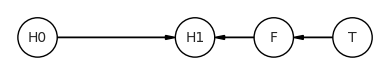

In [21]:
import daft
from causalgraphicalmodels import CausalGraphicalModel

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"],
    edges=[("H0", "H1"),
           ("F", "H1"),
           ("T", "F")])
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [22]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('H1', 'T', {'F'})
('T', 'H0', set())
('F', 'H0', set())


#### Code 6.20

In [23]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0,1], N/2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})

d.describe().T

,count,mean,std,min,25%,50%,75%,max
h0,1000.0,10.088287,1.923554,4.125506,8.815236,10.054380,11.428348,16.570629
h1,1000.0,16.627502,2.677626,7.839070,14.730026,16.606348,18.545594,24.136891
treatment,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000
fungus,1000.0,0.487000,0.500081,0.000000,0.000000,0.000000,1.000000,1.000000


Re-run m_6_6 and m_6_7 on this dataset

#### Code 6.21

Including a python implementation of the sim_happiness function

In [24]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=['age', 'happiness', 'married'])
    popn.loc[:, 'age'] = np.repeat(np.arange(65), 20)
    popn.loc[:, 'happiness'] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, 'married'] = np.array(popn.loc[:, 'married'].values, dtype='bool')

    for i in range(N_years):
        # age population
        popn.loc[:, 'age'] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, 'age'] = 0
        popn.loc[ind, 'married'] = False
        popn.loc[ind, 'happiness'] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, 'happiness'] - 4)) == 1
        popn.loc[elligible, 'married'] = marry

    popn.sort_values('age', inplace=True, ignore_index=True)
    
    return popn

In [25]:
popn = sim_happiness()

In [26]:
popn.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1300.0,3.200000e+01,18.768883,0.0,16.0,3.200000e+01,48.0,64.0
happiness,1300.0,-1.024821e-16,1.214421,-2.0,-1.0,-1.110223e-16,1.0,2.0


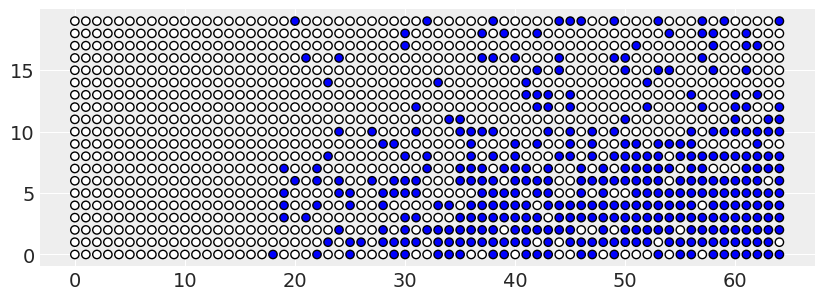

In [27]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

for age, g in popn.groupby('age'):
    colors = np.array(['w'] * 20)
    colors[g.married] = 'b'
    ax.scatter([age] * 20, np.arange(20), edgecolor='k', color=colors)

#### Code 6.22

In [28]:
adults = popn.loc[popn.age > 17]
adults.loc[:, 'A'] = (adults.loc[:, 'age'] - 18) / (65 - 18)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Code 6.23

In [29]:
mid = pd.Categorical(adults.loc[:, 'married'].astype(int))

with pm.Model() as m_6_9:
    a = pm.Normal('a', 0, 1, shape=2)
    bA = pm.Normal('bA', 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential('sigma', 1)
    
    happiness = pm.Normal('happiness', mu, sigma, observed=adults.happiness.values)
    
    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains, 0 divergences: 100%|█████

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.202,0.069,-0.332,-0.072,0.002,0.002,840.0,840.0,838.0,970.0,1.0
a[1],1.212,0.093,1.039,1.384,0.003,0.002,801.0,791.0,802.0,860.0,1.0
bA,-0.713,0.126,-0.942,-0.473,0.005,0.003,749.0,746.0,744.0,909.0,1.0
sigma,1.021,0.024,0.977,1.065,0.001,0.001,1102.0,1101.0,1103.0,1147.0,1.0


#### Code 6.24

In [30]:
with pm.Model() as m6_10:
    a = pm.Normal('a', 0, 1)
    bA = pm.Normal('bA', 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential('sigma', 1)
    
    happiness = pm.Normal('happiness', mu, sigma, observed=adults.happiness.values)
    
    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1252.55draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.078,-0.156,0.136,0.003,0.002,888.0,672.0,887.0,800.0,1.01
bA,0.001,0.136,-0.230,0.272,0.005,0.004,894.0,656.0,903.0,873.0,1.00
sigma,1.216,0.029,1.161,1.269,0.001,0.001,1019.0,1017.0,1023.0,1002.0,1.00


#### Code 6.25

In [31]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [32]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({'C': C, 'P': P, 'G': G, 'U': U})

Text(0, 0.5, 'grandchild education (C)')

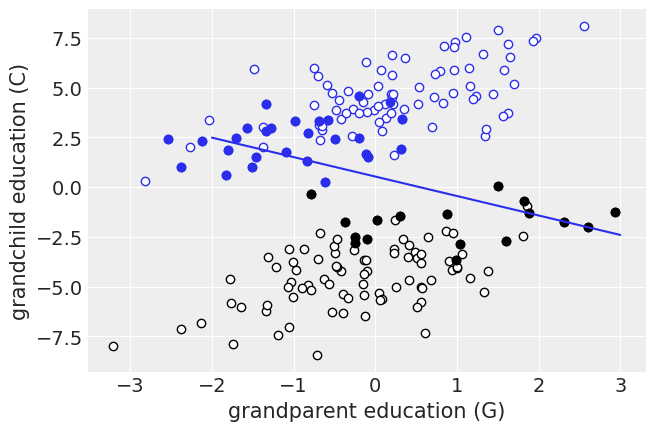

In [33]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color='w', lw=1, edgecolor='C0')
plt.scatter(G[bad], C[bad], color='w', lw=1, edgecolor='k')

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color='C0', lw=1, edgecolor='C0')
plt.scatter(G[bad & eP], C[bad & eP], color='k', lw=1, edgecolor='k')


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2,3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel('grandparent education (G)')
plt.ylabel('grandchild education (C)')

#### Code 6.27

In [34]:
with pm.Model() as m_6_11:
    a = pm.Normal('a', 0, 1)
    p_PC = pm.Normal('b_PC', 0, 1)
    p_GC = pm.Normal('b_GC', 0, 1)
    
    mu = pm.Deterministic('mu', a + p_PC * d.P + p_GC * d.G)
    sigma = pm.Exponential('sigma', 1)
    
    pC = pm.Normal('C', mu, sigma, observed=d.C)
    
    m_6_11_trace = pm.sample()
    
az.summary(m_6_11_trace, var_names=['~mu'], credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_GC, b_PC, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1312.85draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.033,0.096,-0.187,0.112,0.003,0.003,1233.0,590.0,1221.0,724.0,1.00
b_PC,1.851,0.044,1.782,1.920,0.001,0.001,925.0,925.0,932.0,716.0,1.02
b_GC,-0.811,0.099,-0.964,-0.655,0.003,0.002,917.0,916.0,924.0,785.0,1.01
sigma,1.353,0.071,1.240,1.460,0.002,0.002,945.0,932.0,974.0,762.0,1.00


#### Code 6.28

In [35]:
with pm.Model() as m_6_12:
    a = pm.Normal('a', 0, 1)
    p_PC = pm.Normal('b_PC', 0, 1)
    p_GC = pm.Normal('b_GC', 0, 1)
    p_U = pm.Normal('b_U', 0, 1)
    
    mu = pm.Deterministic('mu', a + p_PC * d.P + p_GC * d.G + p_U * d.U)
    sigma = pm.Exponential('sigma', 1)
    
    pC = pm.Normal('C', mu, sigma, observed=d.C)
    
    m_6_12_trace = pm.sample()
    
az.summary(m_6_12_trace, var_names=['~mu'], credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 836.63draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.009,0.072,-0.124,0.102,0.003,0.002,697.0,487.0,685.0,594.0,1.0
b_PC,1.040,0.074,0.927,1.162,0.004,0.003,286.0,285.0,287.0,466.0,1.0
b_GC,-0.010,0.097,-0.157,0.158,0.005,0.004,336.0,336.0,337.0,568.0,1.0
b_U,2.007,0.164,1.756,2.257,0.010,0.007,297.0,297.0,298.0,455.0,1.0
sigma,1.001,0.049,0.927,1.083,0.002,0.001,741.0,741.0,733.0,680.0,1.0


#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [36]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[("X", "Y"), ("U", "X"), ("A", "U"), ("A", "C"),
           ("C", "Y"), ("U", "B"), ("C", "B")])
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'C'})
frozenset({'A'})


#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [37]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[("S", "A"), ("A", "D"),
           ("S", "M"), ("M", "D"),
           ("S", "W"), ("W", "D"),
           ("A", "M")])
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s)for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'M', 'A'})


#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [38]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('S', 'D', {'W', 'M', 'A'})
('M', 'W', {'S'})
('W', 'A', {'S'})
